In [2]:
from copy import deepcopy
import json
import time

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import mean_absolute_percentage_error, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import dowhy
from dowhy import CausalModel

from econml.metalearners import SLearner, XLearner, TLearner
from econml.dml import LinearDML, CausalForestDML, DML
from econml.dr import DRLearner, SparseLinearDRLearner

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor, LGBMClassifier

import networkx as nx

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

C:\Users\aleks\anaconda3\envs\causal_book_py38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dowhy.__version__

'0.8'

In [22]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

# Chapter 10



## Doubly Robust Methods: Let’s Get More!

In [4]:
def plot_effect(effect_true, effect_pred, figsize=(10, 7), ylim=(5000, 22000)):
    plt.figure(figsize=figsize)
    plt.scatter(effect_true, effect_pred, color=COLORS[0])
    plt.plot(np.sort(effect_true), np.sort(effect_true), color=COLORS[1], alpha=.7, label='Perfect model')
    plt.xlabel('$True\ effect$', fontsize=14, alpha=.5)
    plt.ylabel('$Predicted\ effect$', fontsize=14, alpha=.5)
    plt.ylim(ylim[0], ylim[1])
    plt.legend()
    plt.show()

### Read the data

In [5]:
# Train set
earnings_interaction_train = pd.read_csv(r'./data/ml_earnings_interaction_train.csv')

# Test set
earnings_interaction_test = pd.read_csv(r'./data/ml_earnings_interaction_test.csv')

In [6]:
earnings_interaction_train.shape, earnings_interaction_test.shape

In [7]:
# Train 
earnings_interaction_train.head()

,age,python_proficiency,took_a_course,earnings
0,23,0.632318,True,139267.0
1,20,0.602551,False,115569.0
2,21,0.518225,False,119142.0
3,25,0.945161,False,130291.0
4,30,0.636251,True,164209.0


In [8]:
# Test
earnings_interaction_test.head()

,age,python_proficiency,took_a_course,true_effect
0,30,0.223877,True,11120.0
1,23,0.394152,True,11970.0
2,37,0.214638,True,11073.0
3,21,0.869069,True,14345.0
4,41,0.833934,True,14169.0


### Define the graph

In [9]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['took_a_course', 'python_proficiency', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings'),
    ('python_proficiency', 'earnings')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string += ']'

In [10]:
# Instantiate the CausalModel 
model = CausalModel(
    data=earnings_interaction_train,
    treatment='took_a_course',
    outcome='earnings',
    effect_modifiers='python_proficiency',
    graph=gml_string
)

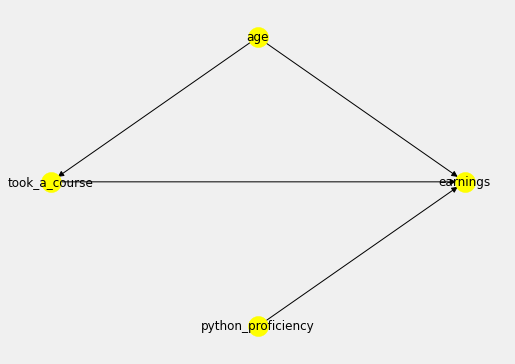

In [11]:
model.view_model()

### Get the estimand

In [12]:
# Get the estimand
estimand = model.identify_effect()

print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimate the effect

In [29]:
# Get estimate (Doubly robust)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dr.LinearDRLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'model_propensity': LogisticRegression(),
            'model_regression': LGBMRegressor(n_estimators=1000, max_depth=10)
        },
        'fit_params': {}
    })

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [30]:
estimate.cate_estimates.mean()

In [31]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [32]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

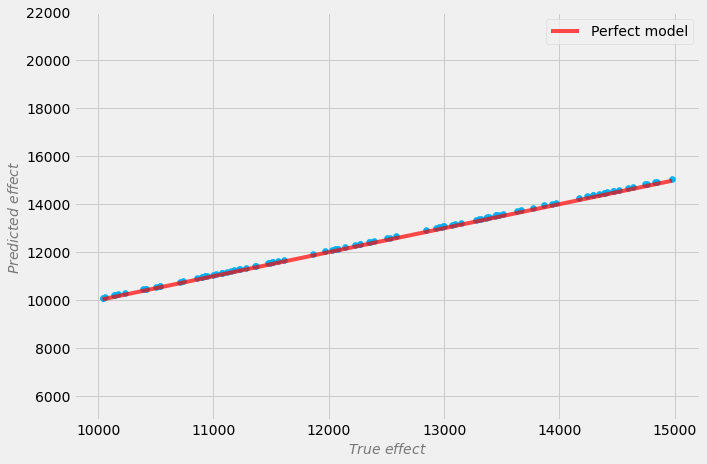

In [33]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

### Non-linear DR

In [71]:
# Get estimate (Doubly robust)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dr.DRLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'model_propensity': LogisticRegression(),
            'model_regression': LGBMRegressor(n_estimators=1000, max_depth=10),
            'model_final': LGBMRegressor(n_estimators=500, max_depth=10),
        },
        'fit_params': {}
    })

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [72]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [73]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

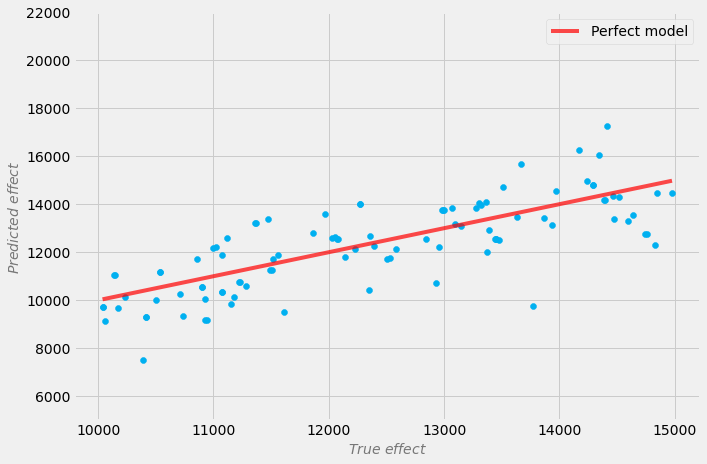

In [74]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

## If Machine Learning is Cool, How About Double Machine Learning?

### Estimate the effect

In [168]:
# Get estimate (DML)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.LinearDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': LGBMRegressor(n_estimators=500, max_depth=10),
            'model_t': LogisticRegression(),
            'discrete_treatment': True
        },
        'fit_params': {}
    })

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [169]:
estimate.cate_estimates.mean()

### Predict on test data

In [170]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [171]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

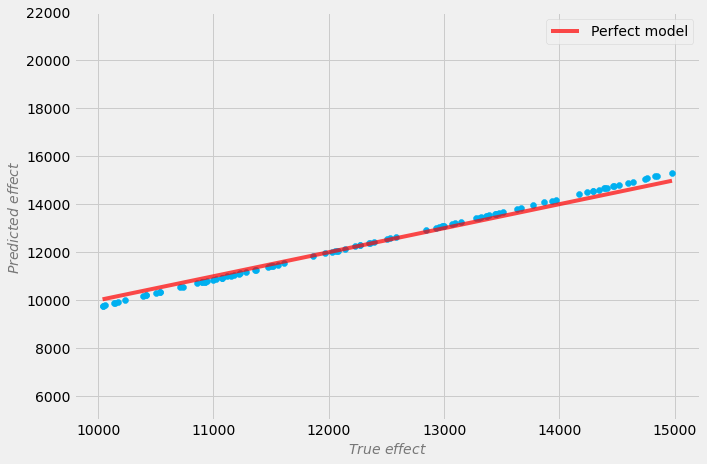

In [172]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

### DML with more folds

In [189]:
# Estimate the effect
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.LinearDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': LGBMRegressor(n_estimators=50, max_depth=10),
            'model_t': LogisticRegression(),
            'discrete_treatment': True,
            'cv': 4
        },
        'fit_params': {
        }
    })

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [190]:
estimate.cate_estimates.mean()

In [191]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [192]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

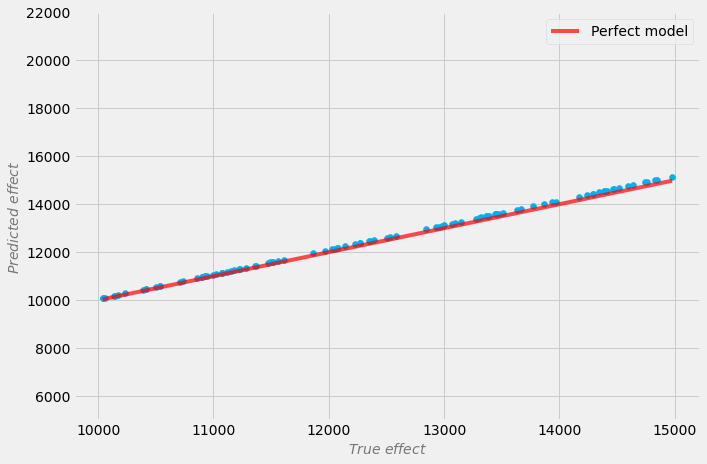

In [193]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

### DML with cross-validation

In [268]:
# Define wrapped CV models
model_y = GridSearchCV(
    estimator=LGBMRegressor(),
    param_grid={
        'max_depth': [3, 10, 20, 100],
        'n_estimators': [10, 50, 100]
    }, cv=10, n_jobs=-1, scoring='neg_mean_squared_error'
)

model_t = GridSearchCV(
    estimator=LGBMClassifier(),
    param_grid={
        'max_depth': [3, 10, 20, 100],
        'n_estimators': [10, 50, 100]
    }, cv=10, n_jobs=-1, scoring='accuracy'
)

In [269]:
# Estimate the effect
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.LinearDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': model_y,
            'model_t': model_t,
            'discrete_treatment': True,
            'cv': 4
        },
        'fit_params': {
        }
    })

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [270]:
estimate.cate_estimates.mean()

In [271]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [272]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

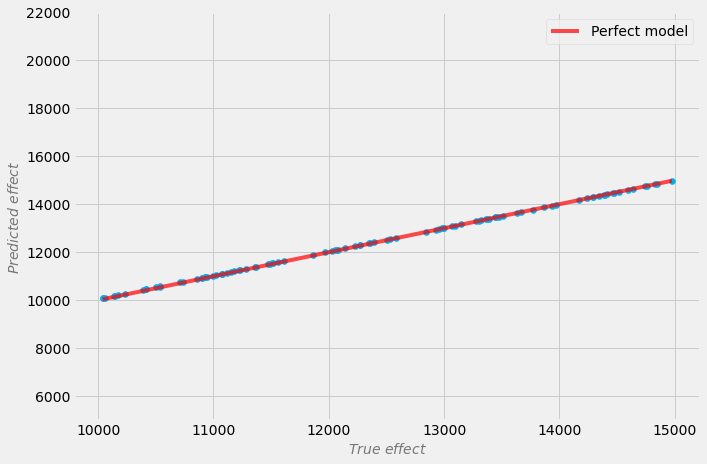

In [273]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

## Causal Forests and more

In [400]:
# Estimate the effect
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.CausalForestDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': LGBMRegressor(n_estimators=50, max_depth=10),
            'model_t': LGBMClassifier(n_estimators=50, max_depth=10),
            'discrete_treatment': True,
            'cv': 4
        },
        'fit_params': {
        }
    }
)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [401]:
estimate.cate_estimates.mean()

In [402]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [403]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

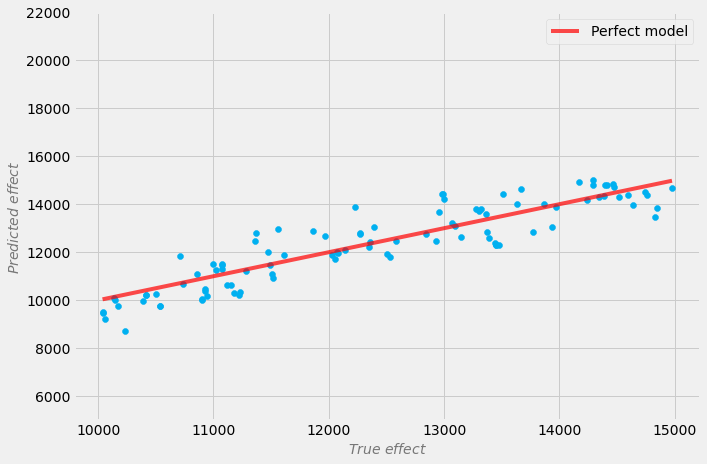

In [404]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

## Heterogenous Treatment Effects With Experimental Data

In [3]:
# Read in the data
hillstrom_clean = pd.read_csv(r'./data/hillstrom_clean.csv')

# Read in labels mapping
with open(r'./data/hillstrom_clean_label_mapping.json', 'r') as f:
    hillstrom_labels_mapping = json.load(f)

In [4]:
hillstrom_clean.head()

,recency,history,mens,womens,newbie,visit,conversion,spend,zip_code__rural,zip_code__surburban,zip_code__urban,channel__multichannel,channel__phone,channel__web,treatment
0,10,142.44,1,0,0,0,0,0.0,0,1,0,0,1,0,1
1,6,329.08,1,1,1,0,0,0.0,1,0,0,0,0,1,0
2,7,180.65,0,1,1,0,0,0.0,0,1,0,0,0,1,1
3,9,675.83,1,0,1,0,0,0.0,1,0,0,0,0,1,2
4,2,45.34,1,0,0,0,0,0.0,0,0,1,0,0,1,1


In [5]:
# Drop redundant cols to avoid multicollinearity
hillstrom_clean = hillstrom_clean.drop(['zip_code__urban', 'channel__web'], axis=1)

### EDA

In [6]:
# Display mapping
hillstrom_labels_mapping

{'control': 0, 'womans_email': 1, 'mens_email': 2}

In [9]:
# P(visit)
hillstrom_clean.visit.mean()

In [10]:
# P(conversion)
hillstrom_clean.conversion.mean()

In [11]:
# Get sample size
sample_size = hillstrom_clean.shape[0]

In [12]:
# Check how random is the treatment assignment

# Split data
hillstrom_X = hillstrom_clean.drop(['visit', 'conversion', 'spend', 'treatment'], axis=1)
hillstrom_Y = hillstrom_clean['spend']
hillstrom_T = hillstrom_clean['treatment']

In [13]:
# P(T=t)
hillstrom_T.value_counts() / sample_size

1    0.334172
2    0.332922
0    0.332906
Name: treatment, dtype: float64

In [12]:
# Train-test split
X_train_eda, X_test_eda, T_train_eda, T_test_eda = train_test_split(hillstrom_X, hillstrom_T, test_size=.5)

In [348]:
# Split quality
T_test_eda.value_counts() / T_test_eda.shape[0]

1    0.335750
0    0.334688
2    0.329562
Name: treatment, dtype: float64

In [322]:
# Fit the EDA model
lgbm_eda = LGBMClassifier()
lgbm_eda.fit(X_train_eda, T_train_eda)

LGBMClassifier()

In [323]:
# Get predictions on the test
T_pred_eda = lgbm_eda.predict(X_test_eda)

# Check accuracy
acc_eda = accuracy_score(T_test_eda, T_pred_eda)
acc_eda

In [324]:
# Generate random data
random_scores = []

test_eda_sample_size = T_test_eda.shape[0]

for i in range(10000):
    random_scores.append(
        (np.random.choice(
            [0, 1, 2], 
            test_eda_sample_size) == np.random.choice(
            [0, 1, 2], 
            test_eda_sample_size)).mean())
    
np.quantile(random_scores, .025), np.quantile(random_scores, .975)

In [325]:
# Get 95% CIs
lower = np.quantile(random_scores, .025)
upper = np.quantile(random_scores, .975)
lower, upper

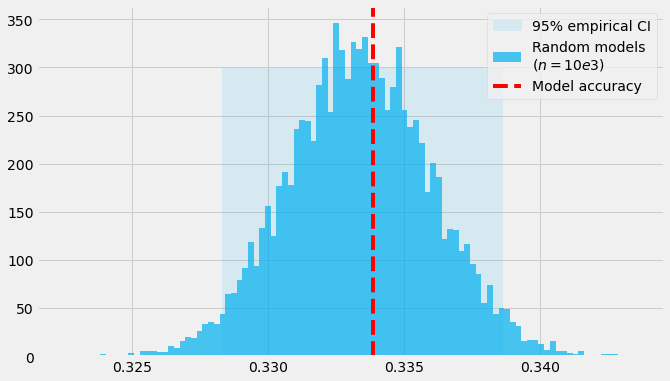

In [331]:
# Plot radom vs accuracy
plt.figure(figsize=(10, 6))
plt.fill_betweenx(
    x1=lower, 
    x2=upper, 
    y=np.arange(0, 300),
    color=COLORS[0],
    alpha=.1,
    label='95% empirical CI'
)
plt.hist(random_scores, alpha=.7, color=COLORS[0], bins=100, label='Random models\n($n=10e3$)')
plt.axvline(acc_eda, color=COLORS[1], ls='--', label='Model accuracy')

plt.legend()
plt.show()

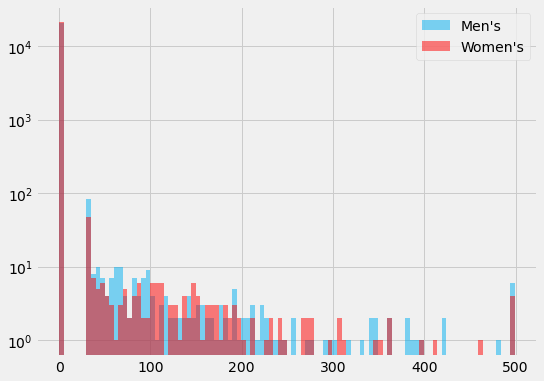

In [148]:
plt.figure(figsize=(8, 6))

plt.hist(
    hillstrom_clean[hillstrom_clean['treatment'] == 2]['spend'], 
    label=f'Men\'s', 
    color=COLORS[0],
    bins=100, 
    alpha=.5)

plt.hist(
    hillstrom_clean[hillstrom_clean['treatment'] == 1]['spend'], 
    label=f'Women\'s',
    color=COLORS[1],
    bins=100, 
    alpha=.5)

plt.legend()
plt.yscale('log')
plt.show()

In [152]:
hillstrom_clean[hillstrom_clean['treatment'] == 1]['spend'].var()

In [129]:
hillstrom_labels_mapping

{'control': 0, 'womans_email': 1, 'mens_email': 2}

### Modeling Hillstrom

In [311]:
# No. of conversions
(hillstrom_Y[hillstrom_T > 0] > 0).sum()

456

In [821]:
# Train test split
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(
    hillstrom_X,
    hillstrom_Y,
    hillstrom_T,
    test_size=.5
)

In [822]:
# How many observations in train/test converted?
(y_train[T_train > 0] > 0).sum(), (y_test[T_test > 0] > 0).sum()

(227, 229)

In [823]:
def create_model(model_type, n_estimators=100, max_depth=10, learning_rate=.01):
    if model_type == 'regressor':
        return LGBMRegressor(
            n_estimators=n_estimators, 
            max_depth=max_depth, 
            learning_rate=learning_rate)
    elif model_type == 'classifier':
        return LGBMClassifier(
            n_estimators=n_estimators, 
            max_depth=max_depth, 
            learning_rate=learning_rate)
    else:
        raise NotImplementedError(f'Model type `{model_type}` not implemented.')

In [824]:
# Models
s_learner = SLearner(
    overall_model=create_model('regressor')
)

x_learner = XLearner(
    models=[
        create_model('regressor'),
        create_model('regressor'),
        create_model('regressor'),
    ],
    cate_models=[
        create_model('regressor'),
        create_model('regressor'),
        create_model('regressor'),
    ]
)

t_learner = TLearner(
    models=[
        create_model('regressor'),
        create_model('regressor'),
        create_model('regressor'),
    ]
)

dml = LinearDML(
    model_y=create_model('regressor'),
    model_t=create_model('classifier'),
    discrete_treatment=True,
    cv=5
)

dr = DRLearner(
    model_propensity=LogisticRegression(),
    model_regression=create_model('regressor'),
    model_final=create_model('regressor'),
    cv=5,
)

cf = CausalForestDML(
    model_y=create_model('regressor'),
    model_t=create_model('classifier'),
    discrete_treatment=True,
    cv=5
)

In [825]:
# Models
models = {
    'SLearner': s_learner,
    'TLearner': t_learner,
    'XLearner': x_learner,
    'DRLearner': dr,
    'LinearDML': dml,
    'CausalForestDML': cf
} 

In [826]:
# Fit the estimator
for model_name, model in models.items():
    start = time.time()
    print(f'Fitting {model_name}')
    model.fit(
        Y=y_train,
        T=T_train,
        X=X_train
    )
    stop = time.time()
    
    print(f'{model_name} fitted in {stop - start:0.4f} seconds.\n')

Fitting SLearner


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


SLearner fitted in 0.2076 seconds.

Fitting TLearner


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


TLearner fitted in 0.3739 seconds.

Fitting XLearner


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


XLearner fitted in 0.9840 seconds.

Fitting DRLearner


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


DRLearner fitted in 2.5961 seconds.

Fitting LinearDML


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


LinearDML fitted in 4.0818 seconds.

Fitting CausalForestDML
CausalForestDML fitted in 5.9465 seconds.



Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [827]:
# Compute effects
effects_train = {
    'treatment_1': {},
    'treatment_2': {}
}

effects_test = {
    'treatment_1': {},
    'treatment_2': {}
}


for treatment in [1, 2]:
    for model_name, model in tqdm(models.items()):
        
        # Compute effects on train
        effects_local_train = models[model_name].effect(X_train.values, T0=0, T1=treatment)
        effects_train[f'treatment_{treatment}'][model_name] = effects_local_train
        
        # Compute effects on test
        effects_local_test = models[model_name].effect(X_test.values, T0=0, T1=treatment)
        effects_test[f'treatment_{treatment}'][model_name] = effects_local_test


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.56it/s]


#### Uplift by decile

In [828]:
def get_uplift_by_decile(uplifts, t_true, t_pred, y_true):
    
    # Encapsulate the data & sort according to uplifts
    all_data = pd.DataFrame(
        dict(
            uplifts=uplifts, 
            y_true=y_true, 
            t_true=t_true)
    ).query(f't_true==0 | t_true=={t_pred}').sort_values('uplifts')
    
    # Partition into deciles
    all_data['deciles'] = pd.qcut(all_data['uplifts'], q=10, labels=np.arange(10), duplicates='raise')
    
    # Get mean responses within deciles
    mean_decile_resp = all_data.groupby(['deciles', 't_true']).mean()
    
    # Compute true decile uplift
    mean_decile_resp['true_uplift'] = mean_decile_resp['y_true'] * np.array([-1, 1]*10)
    true_uplift = mean_decile_resp.groupby(level=[0]).sum()['true_uplift']  
    
    return true_uplift[::-1]

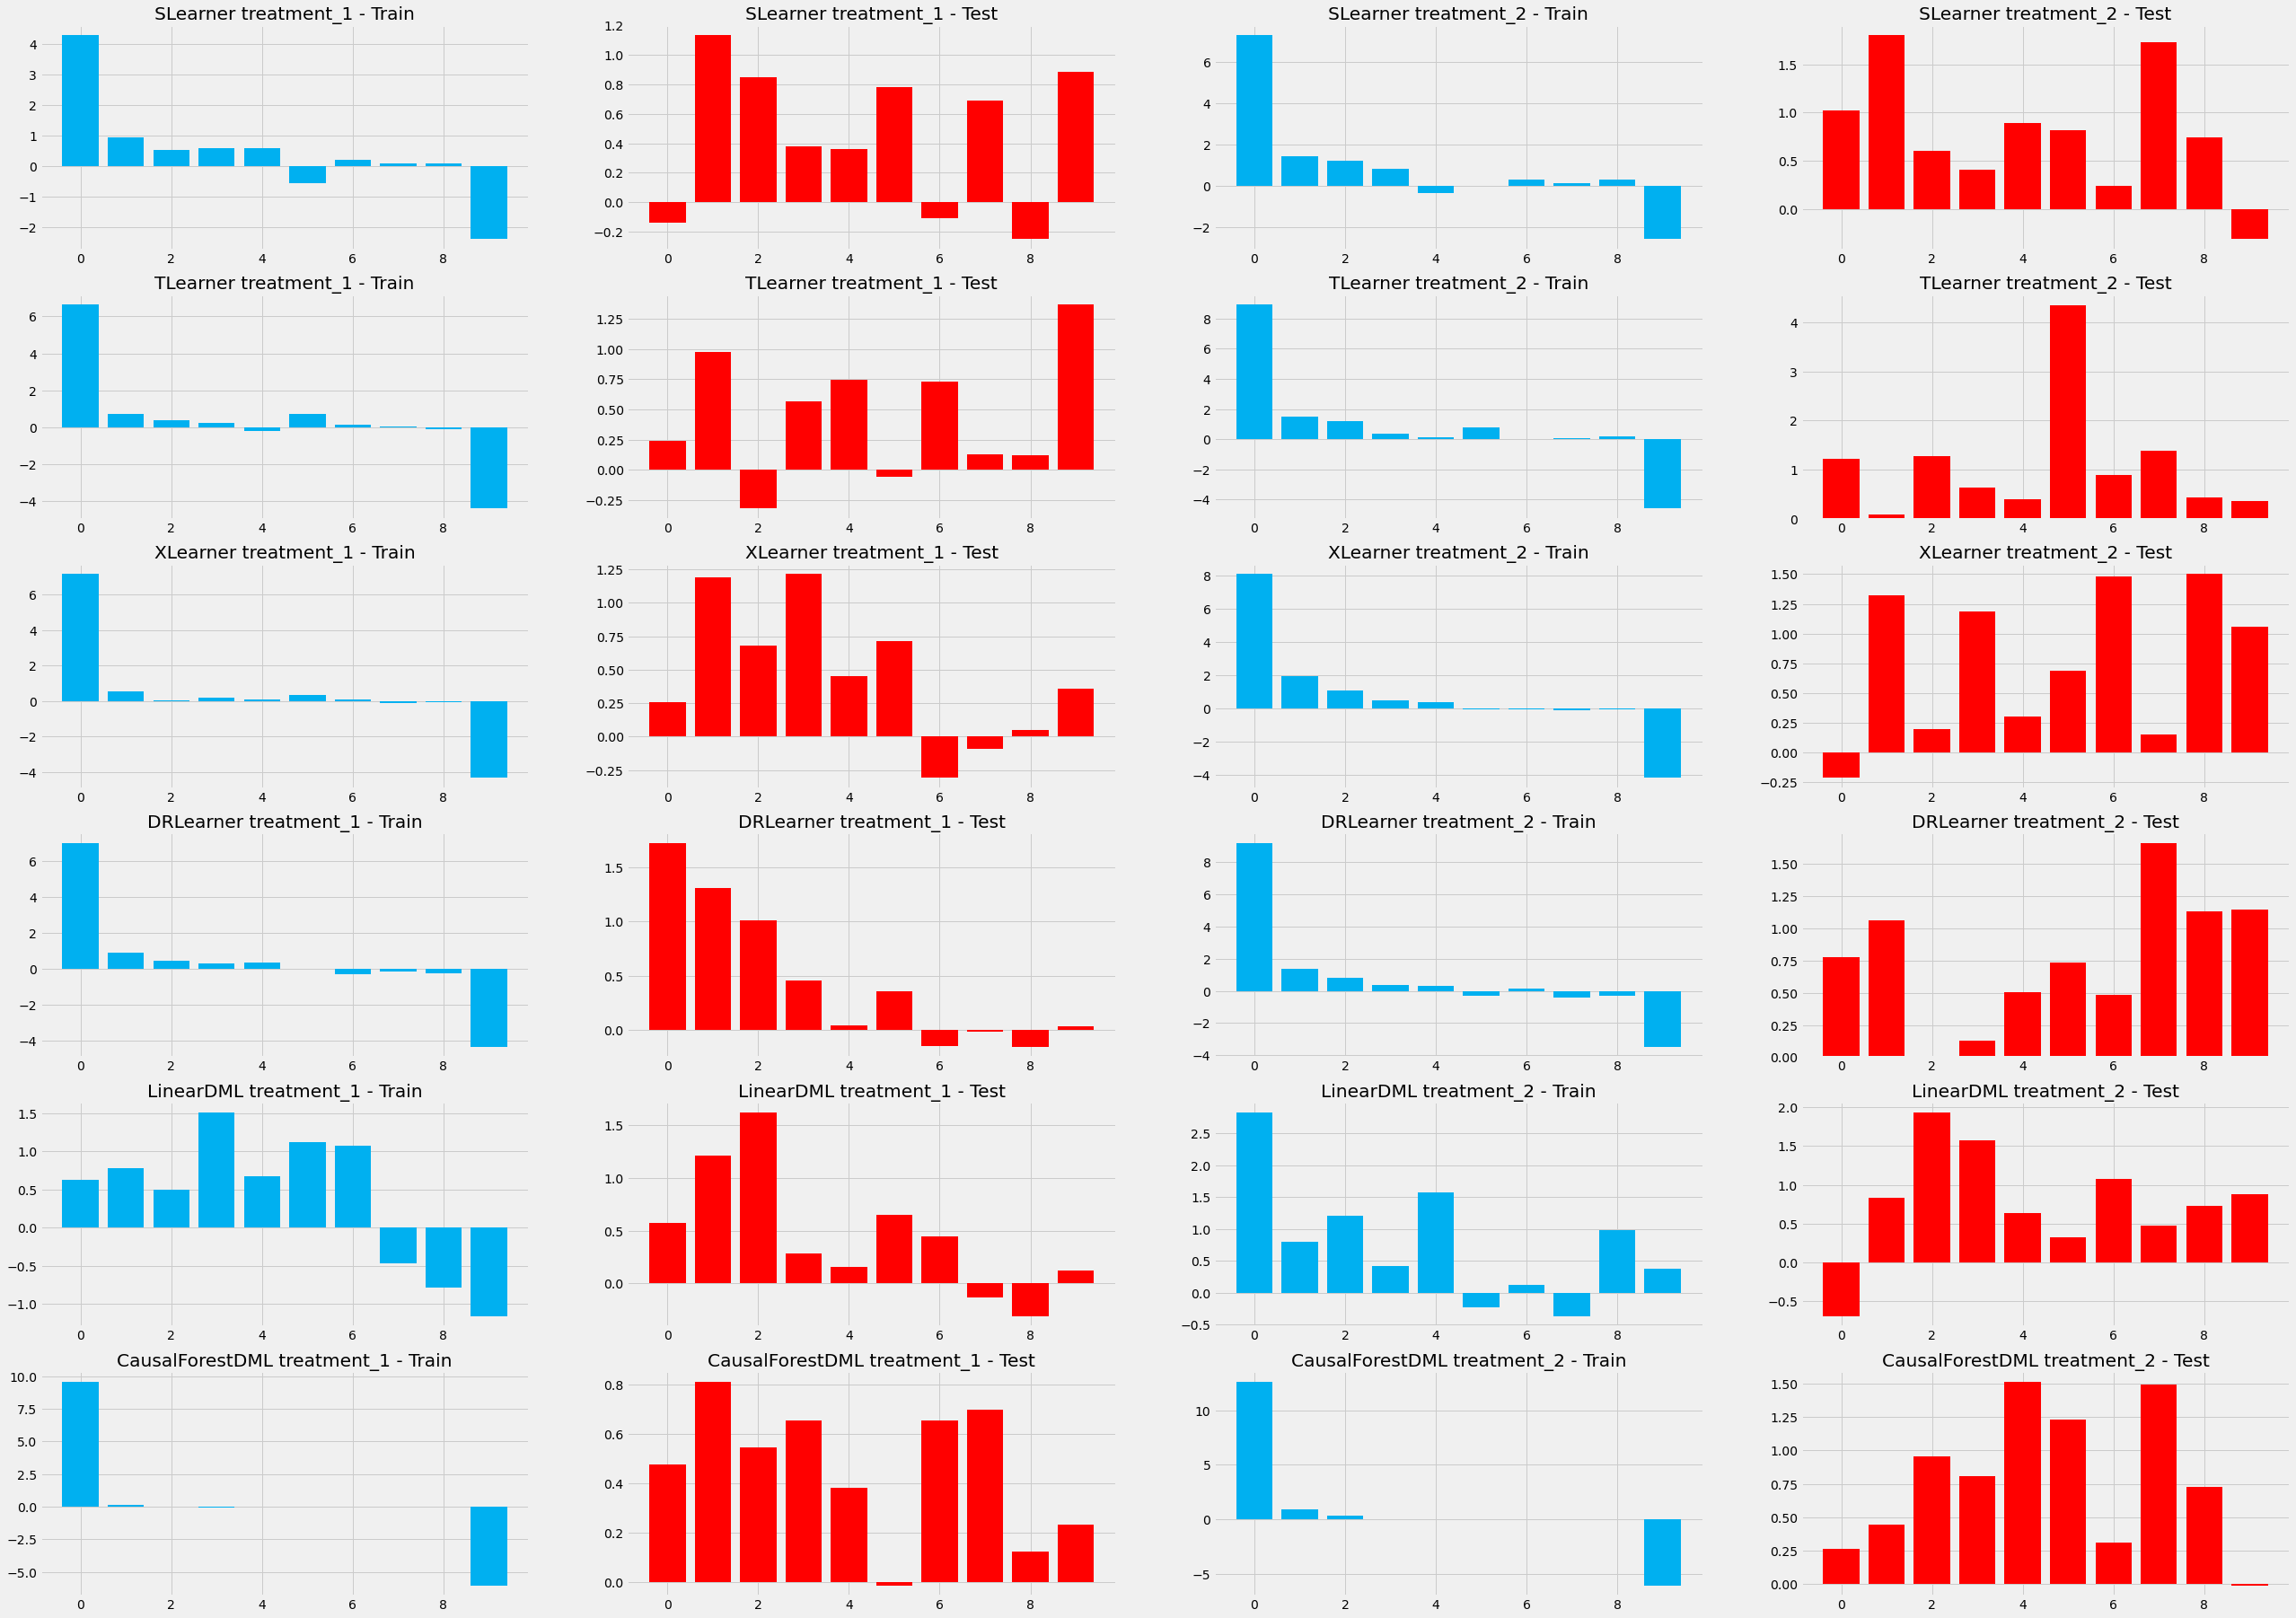

In [829]:
plt.figure(figsize=(40, 30))

i = 1

for model_name in models.keys():
    
    uplifts_by_decile = {
        'treatment_1': {},
        'treatment_2': {}
    }
    
    global_min = np.inf
    global_max = -np.inf
    
    for treatment in ['treatment_1', 'treatment_2']:

        uplift_by_decile_train = get_uplift_by_decile(
            uplifts=effects_train[treatment][model_name], 
            t_true=T_train,
            t_pred=int(treatment.split('_')[-1]),
            y_true=y_train
        )

        uplift_by_decile_test = get_uplift_by_decile(
            uplifts=effects_test[treatment][model_name], 
            t_true=T_test,
            t_pred=int(treatment.split('_')[-1]),
            y_true=y_test
        )
            
        plt.subplot(6, 4, i)
        plt.bar(np.arange(10), uplift_by_decile_train, color=COLORS[0])
        plt.title(f'{model_name} {treatment} - Train')
        
        plt.subplot(6, 4, i + 1)
        plt.bar(np.arange(10), uplift_by_decile_test, color=COLORS[1])
        plt.title(f'{model_name} {treatment} - Test')
        
        i += 2
        
plt.show()

#### Expected response

As introduced by [Zhao et al., 2017](https://arxiv.org/pdf/1705.08492.pdf)

Formula:

$$\Large Z = \sum_{t=0}^K \frac{1}{P(T=t)}y \mathbb{I}_{h(x)=t}\mathbb{I}_{T=t}$$

<br>


* $K$ is a number of treatment levels

* $\mathbb{I}$ is an indicator function

* $h(x)$ is the treatment recommended by the model (treatment leading to the highest uplift)

In [830]:
def get_effects_argmax(effects_arrays, return_matrix=False):
    """Returns argmax for each row of predicted effects for the arbitrary no. of treatments.
    
    :param effects_arrays: A list of arrays for K treatments, where K>=1 (without control null effects)
    :type effects_arrays: list of np.arrays
    
    :param return_matrix: Determines if the function returns a matrix of all effects 
        (with added null effect for control)
    :type return_matrix: bool

    ...
    :return: A stacked matrix of all effects with added column for control effects (which is always 0)
    :rtype: np.array
    """
    
    n_rows = effects_arrays[0].shape[0]
    null_effect_array = np.zeros(n_rows)
    stacked = np.stack([null_effect_array] + effects_arrays).T
    
    if return_matrix:
        return np.argmax(stacked, axis=1), stacked
    
    return np.argmax(stacked, axis=1)


def get_expected_response(y_true, t_true, effects_argmax):
    """Computes the average expected response for an uplift model according to the formula
        proposed by: 
        Zhao, Y., Fang, X., & Simchi-Levi, D. (2017). Uplift Modeling with Multiple Treatments and General Response Types. 
        Proceedings of the 2017 SIAM International Conference on Data Mining, 588-596. 
        Society for Industrial and Applied Mathematics.   
    """
    
    proba_t = pd.Series(t_true).value_counts() / np.array(t_true).shape[0]
    treatments = proba_t.index.values
    
    z_vals = 0
    
    for treatment in treatments:
        h_indicator = effects_argmax == treatment
        t_indicator = t_true == treatment
        t_proba_local = proba_t[treatment]
        
        z_vals += (1/t_proba_local) * y_true * h_indicator * t_indicator
    
    return z_vals.mean()

In [833]:
# Compute expected response
print('Expecetd response on train:\n')
for model_name in models:
    effects_argmax = get_effects_argmax(
        [
            effects_train['treatment_1'][model_name],
            effects_train['treatment_2'][model_name]
        ]
    )
    
    expected_response = get_expected_response(
        y_true=y_train, 
        t_true=T_train, 
        effects_argmax=effects_argmax
    )
    
    print(f'{model_name}: {expected_response}')
    
print('\n' + '-'*30)
    
print('Expected response on test:\n')
for model_name in models:
    effects_argmax = get_effects_argmax(
        [
            effects_test['treatment_1'][model_name],
            effects_test['treatment_2'][model_name]
        ]
    )
    
    expected_response = get_expected_response(
        y_true=y_test, 
        t_true=T_test, 
        effects_argmax=effects_argmax
    )
    
    print(f'{model_name}: {expected_response}')

Expecetd response on train:

SLearner: 2.004509358884219
TLearner: 2.499033323345889
XLearner: 2.3844783394170035
DRLearner: 2.357949913732327
LinearDML: 1.5596898804820036
CausalForestDML: 2.9583483277085936

------------------------------
Expected response on test:

SLearner: 1.3498049695400602
TLearner: 1.2108070097957537
XLearner: 1.2901946274863276
DRLearner: 1.500974856751045
LinearDML: 1.3496321556492639
CausalForestDML: 1.3114730998145985


In [834]:
# Outcome in the whole dataset
hillstrom_clean.groupby('treatment')['spend'].mean()

treatment
0    0.652789
1    1.077202
2    1.422617
Name: spend, dtype: float64

#### Confidence intervals

In [835]:
models['LinearDML'].effect_interval(X=X_test, T0=0, T1=1)

(array([-1.41417908, -0.40901173, -1.50891344, ..., -0.27946152,
        -0.8185368 , -0.92689394]),
 array([0.88022207, 1.03706657, 3.34888932, ..., 2.47925003, 1.75716167,
        1.51788005]))

In [844]:
models['LinearDML'].effect_interval(X=X_test.iloc[0:1, :], T0=0, T1=1)

(array([-1.41417908]), array([0.88022207]))

In [836]:
# CIs (DML)
ints = np.stack(models['LinearDML'].effect_interval(X=X_test, T0=0, T1=1, alpha=.05)).T

# What % of effects contains zero?
(np.sign(ints[:, 0]) == np.sign(ints[:, 1])).sum() / ints.shape[0]